In [1]:
CLOUD = True
CLOUD_SINGLE = False

import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

VERSION = 9

In [2]:
if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [3]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [5]:
cols_cat, cols_float = pickle.load(open(PATH_WORK/'covs','rb'))

In [6]:
filename = PATH_WORK/'indexes_file.pkl'
all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

In [7]:
trn_data = train_md.loc[train_md.img_id.isin(all_idx[train_ids])]
val_data = train_md.loc[train_md.img_id.isin(all_idx[val_ids])]

In [8]:
assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
    == len(train_md.SeriesInstanceUID.unique())

In [9]:
assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
    >= len(train_md.PatientID.unique())

In [10]:
ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
ids_df = ids_df.join(train_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

assert len(ids_df.SeriesInstanceUID.unique()) == 19530

In [11]:
test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

In [12]:
filename = PATH_WORK/'test_indexes.pkl'
test_ids = pickle.load(open(filename,'rb'))

In [13]:
test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
test_ids_df = test_ids_df.join(test_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

assert len(test_ids_df.SeriesInstanceUID.unique()) == 2214

In [14]:
pd.concat([test_md[cols_cat + cols_float].mean(0),
           trn_data[cols_cat + cols_float].mean(0),
           val_data[cols_cat + cols_float].mean(0)],axis=1)

,0,1,2
BitsStored,0.040435,0.493129,0.494393
PixelRepresentation,0.039672,0.489732,0.491567
RescaleIntercept,0.001884,0.025994,0.023441
WindowCenter_1_NAN,0.040435,0.493129,0.494393
ImageOrientationPatient_0,0.999491,0.999703,0.999969
ImageOrientationPatient_1,-0.000509,0.000072,0.000118
ImageOrientationPatient_2,0.000000,0.000015,-0.000118
ImageOrientationPatient_3,0.000495,-0.000066,-0.000132
ImageOrientationPatient_4,0.948793,0.973095,0.972877
ImageOrientationPatient_5,-0.285991,-0.154848,-0.156091


In [15]:
meta_cols = ['pos_size','pos_idx','pos_inc','pos_rel','pos_zeros']

In [16]:
meta_cols = cols_cat + cols_float

# Pre-processing

In [17]:
if False:
    filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


    filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(test_ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(test_ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Model

In [18]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [19]:
all_black = '006d4432e'

path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
black_feats = pickle.load(open(path,'rb'))[41]

In [20]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, ids_df, mode='train', bs=None):
        
        super(RSNA_DataSet, self).__init__()
        
        md = metadata.copy()
        md = md.reset_index(drop=True)
        series = md.SeriesInstanceUID.unique()
        
        samples_add = 0
        if mode != 'train':
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series,np.repeat(series[0],samples_add)])
        self.metadata = md
        self.ids_df = ids_df
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        
        folder = 'test' if self.mode == 'test' else 'train'
        path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
        feats = pickle.load(open(path,'rb'))
        ids_df_sub = self.ids_df.loc[self.ids_df.SeriesInstanceUID.values == series_id]
        
        if feats.shape[0] > len(df):
            mask_dup = ~ids_df_sub.img_id.duplicated().values
            ids_df_sub = ids_df_sub.loc[mask_dup]
            feats = feats[torch.BoolTensor(mask_dup)]
        
        assert feats.shape[0] == len(df)
        assert len(ids_df_sub) == len(df)
        assert np.all(ids_df_sub.img_id.isin(df.img_id).values)
        order = np.argsort(ids_df_sub.pos_idx.values)
        assert np.all(ids_df_sub.img_id.values[order] == df.img_id.values)
        feats = feats[torch.LongTensor(order)]
        
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        target = torch.Tensor(df[all_ich].values)
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        if offset > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(offset,1), feats], dim=0)
            target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        if (60 - len(df) - offset) > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(60 - len(df) - offset,1)], dim=0)
            target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats.shape[0] == 60
        assert target.shape[0] == 60
        
        feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, target
        else:
            return feats, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [21]:
class _Loss(nn.Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class BCEWithLogitsLoss(_Loss):
    __constants__ = ['weight', 'pos_weight', 'reduction']

    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None):
        super(BCEWithLogitsLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.register_buffer('pos_weight', pos_weight)
    
    def forward(self, input, target):
        #((torch.log(1+torch.exp(input)) - target*input)*self.weight).mean()
        return F.binary_cross_entropy_with_logits(input.squeeze(), target,
                                                  self.weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [22]:
class FeatProduct(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(FeatProduct, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(out_feature, in_feature))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        output = F.linear(x, self.weight)
        return output

In [23]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [24]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., use_bn:bool=True, bn_final:bool=False, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.n_cont = n_cont
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        self.feat_product = FeatProduct(feat_sz + n_cont, 20)
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)

    def get_sizes(self, layers, out_sz):
        return [1200] + layers + [out_sz]

    def forward(self, x) -> torch.Tensor:
        x = self.bn_cont(x)
        x = x.transpose(1,2)
        #x = self.fc_drop(x)
        x = self.feat_product(x)
        #x = self.relu(x)
        x = x.reshape(x.shape[0],-1)
        x = self.layers(x)
        x = x.reshape(x.shape[0],60,6)
        return x

In [25]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# TPU

In [26]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 5
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()
    
    st = time.time()
    for i, (x, y) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        loss.backward()
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x

In [27]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 1
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
                
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [28]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    
    for i, (x, y, idx) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, idx
    
    return np.concatenate(results), np.concatenate(indices)

In [29]:
def train_one(weight=None, load_model=True, epochs=1, bs=100):
    
    cur_epoch = getCurrentBatch()
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    trn_ds = RSNA_DataSet(trn_data, ids_df, mode='train', bs=bs)
    loader = D.DataLoader(trn_ds, num_workers=16 if CLOUD else 0, batch_size=bs, shuffle=True)
    val_ds = RSNA_DataSet(val_data, ids_df, mode='valid', bs=bs)
    loader_val = D.DataLoader(val_ds, num_workers=16 if CLOUD else 0, batch_size=bs, shuffle=True)
    #tst_ds = RSNA_DataSet(test_md, test_ids_df, mode='test')
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    model = TabularModel(n_cont = len(meta_cols), out_sz=360, layers=[500,200], ps=[0.5,0.5], bn_final=True)
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    
    model_file_name = modelFileName(return_last=True)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if CLOUD and (not CLOUD_SINGLE):
        model_parallel = dp.DataParallel(model, device_ids=devices)
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()

        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            state_dict = model_parallel._models[0].state_dict()
        else:
            results = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(val_data.SeriesInstanceUID.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        valid_time = time.time()-st
        
        loc_data = val_data.copy()
        if DATA_SMALL:
            val_sz = int(0.01*len(val_data.SeriesInstanceUID.unique()))
            val_series = val_data.SeriesInstanceUID.unique()[:val_sz]
            loc_data = loc_data.loc[val_data.SeriesInstanceUID.isin(val_series)]
        
        val_results = np.zeros((len(loc_data),6))
        for k, series in enumerate(loc_data.SeriesInstanceUID.unique()):
            mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + mask.sum()) <= 60
            val_results[mask] = predictions[k,offsets[k]:(offsets[k] + mask.sum())]
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]

        print('epoch {}, val ll: {:.4f}, cor: {:.4f}'.format(i, ll, cor))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(0,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    return model, predictions

In [30]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [31]:
# mixup
# position randomization
# one-cycle
# fill empty with all black features, and meta of the last

# Yuval: zoom in, squish, perspective wraping

In [34]:
DATA_SMALL = False
learning_rate = 0.5
weight_decay = 1e-4
model, predictions = train_one(epochs=2, bs=100)

completed epochs: 2 starting now: 2
adding dummy serieses 447
dataset train: 17577 valid: 2400 loader train: 176 valid: 24
loading model model.b2.f0.v9
Batch 5 device: xla:1 time passed: 84.205 time per batch: 16.841
Batch 10 device: xla:1 time passed: 124.015 time per batch: 12.402
Batch 15 device: xla:1 time passed: 164.572 time per batch: 10.971
Batch 20 device: xla:1 time passed: 204.773 time per batch: 10.239
Batch 1 device: xla:1 time passed: 21.843 time per batch: 21.843
Batch 2 device: xla:1 time passed: 22.013 time per batch: 11.007
Batch 3 device: xla:1 time passed: 22.222 time per batch: 7.407
epoch 3, val ll: 0.2605, cor: 0.0746
Batch 5 device: xla:1 time passed: 83.499 time per batch: 16.700


KeyboardInterrupt: 

In [33]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.259910,0.081396,0.385425,0.110771,0.236980,0.209428,0.229393,0.261946,17577,2400,100,221.740387,40.232106,0.5,0.0001
1,2,0,0.238176,0.313776,0.347896,0.109068,0.219997,0.188093,0.210198,0.244083,17577,2400,100,222.574692,39.632468,0.5,0.0001


In [140]:
predictions.mean((0,1))

array([0.540385  , 0.30819952, 0.43251818, 0.3530488 , 0.43293434,
       0.41421852], dtype=float32)

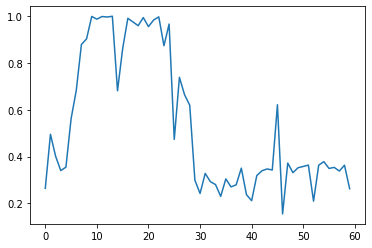

In [141]:
plt.plot(predictions.mean(0)[:,0])

# Inference

In [127]:
def inference_one(bs = 100):
    st = time.time()

    cur_epoch = getCurrentBatch()
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    model_file_name = modelFileName(return_last=True)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)

    setSeeds(SEED + cur_epoch)

    if CLOUD and (not CLOUD_SINGLE):
        model_parallel = dp.DataParallel(model, device_ids=devices)

    tst_ds = RSNA_DataSet(test_md, test_ids_df, mode='test', bs=bs)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))

    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions, indices = np.stack(results)
    else:
        predictions, indices = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    print('test processing time:', time.time() - st)
    
    return predictions

In [128]:
DATA_SMALL = False
predictions = inference_one()

completed epochs: 2
loading model model.b2.f0.v3
adding test serieses 86
dataset test: 2300 loader test: 23
B10 -> time passed: 17.695 time per batch: 1.769
B20 -> time passed: 35.067 time per batch: 1.753
test processing time: 40.454989433288574


In [129]:
predictions.mean((0,1))

array([0.40144655, 0.42193368, 0.3991171 , 0.3763159 , 0.45404765,
       0.4236126 ], dtype=float32)

In [70]:
predictions.mean((0,1))

array([0.087846, 0.004184, 0.029325, 0.030316, 0.041098, 0.029221], dtype=float32)

In [130]:
sub = pd.DataFrame()
for i, series_id in enumerate(test_md.SeriesInstanceUID.unique()):
    df = test_md.loc[test_md.SeriesInstanceUID == series_id]
    id_column = [a + '_' + b for a in df.SOPInstanceUID for b in all_ich]
    data_sub = pd.DataFrame({'ID':np.array(id_column), 'Label':predictions[i,:len(df)].reshape(-1)})
    sub = pd.concat([sub,data_sub], axis=0, sort=False)

sub = sub.reset_index(drop=True)

assert len(sub) == 6*len(test_md)

In [136]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.40976402

In [72]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1471214

In [57]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1255341744607709

In [73]:
sub.to_csv(PATH/'submission.csv', index=False)

In [59]:
best_sub = pd.read_csv(PATH/'submission20.csv')

In [74]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9499705853123557